# Пункт 1
## Скачиваем набор кредитных карт

In [1]:
import pandas as pd

url = 'credit_card_defaulter.csv'
card_f = pd.read_csv(url)
card_f.tail()

,Unnamed: 0,default,student,balance,income
9995,9996,No,No,711.555020,52992.37891
9996,9997,No,No,757.962918,19660.72177
9997,9998,No,No,845.411989,58636.15698
9998,9999,No,No,1569.009053,36669.11236
9999,10000,No,Yes,200.922183,16862.95232


## Статистика по переменным

In [2]:
card_f.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  10000 non-null  int64  
 1   default     10000 non-null  object 
 2   student     10000 non-null  object 
 3   balance     10000 non-null  float64
 4   income      10000 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 390.8+ KB


В наборе нет пропущенных значений, так как для любой переменной одинаковое количество ненулевых значений. balance, income имеют значение с плавающей точкой. Количество объектов - 10000.
### Статистика для default, student

In [3]:
print(card_f['default'].value_counts())
print(card_f['student'].value_counts())

No     9667
Yes     333
Name: default, dtype: int64
No     7056
Yes    2944
Name: student, dtype: int64


default, student имеют значения да/нет. default - характеристика классов. Соответственно, имеем два класса: да и нет (да - неплательщик по кредиту, и нет - плательщик по кредиту). 
### Статистика для balance, income

In [4]:
card_f.describe()

,Unnamed: 0,balance,income
count,10000.00000,10000.000000,10000.000000
mean,5000.50000,835.374886,33516.981876
std,2886.89568,483.714985,13336.639563
min,1.00000,0.000000,771.967729
25%,2500.75000,481.731105,21340.462905
50%,5000.50000,823.636973,34552.644800
75%,7500.25000,1166.308387,43807.729275
max,10000.00000,2654.322576,73554.233500


Видим основные характеристики набора данных.
# Пункт 2
## Преобразование данных

In [5]:
from sklearn.preprocessing import LabelEncoder

card_f.set_index("Unnamed: 0", inplace=True)
card_f.index.name=None

enc = LabelEncoder()
card_f.default = enc.fit_transform(card_f.default)
card_f.student = enc.fit_transform(card_f.student)

card_f.tail()

,default,student,balance,income
9996,0,0,711.555020,52992.37891
9997,0,0,757.962918,19660.72177
9998,0,0,845.411989,58636.15698
9999,0,0,1569.009053,36669.11236
10000,0,1,200.922183,16862.95232


## Построение и визуализация дерева решений

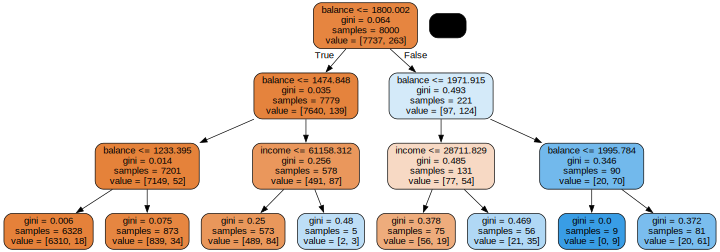

In [6]:
from sklearn import tree
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import graphviz
import pydotplus

X = card_f.iloc[:, 1:]
y = card_f.default

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=27)
X_train1, X_test1, y_train1, y_test1 = X_train, X_test, y_train, y_test

clf = tree.DecisionTreeClassifier(max_depth = 3)
clf.fit(X_train1, y_train1)

dot_data = tree.export_graphviz(clf, out_file=None, feature_names = X_train.columns, filled=True, rounded=True)

pydot_graph = pydotplus.graph_from_dot_data(dot_data)
pydot_graph.set_size('"10!"')

graphviz.Source(pydot_graph.to_string())

## Метрики качества классификации

In [7]:
from sklearn.metrics import accuracy_score, classification_report

y_pred1 = clf.predict(X_test1)
print('Accuracy: ', accuracy_score(y_test1, y_pred1))
print(classification_report(y_test1, y_pred1))

Accuracy:  0.9695
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1930
           1       0.62      0.34      0.44        70

    accuracy                           0.97      2000
   macro avg       0.80      0.67      0.71      2000
weighted avg       0.96      0.97      0.97      2000



Видно, что класс плательщиков по кредиту вычисляется точнее: их больше, чем неплательщиков.
Исходя из данного построения дерева, можно выявить следующие правила:
#### если balance <= 1474.848, то неплательщик
#### если 1474.848 < balance <= 1800.002 и income <= 61158.312, то неплательщик
#### если balance > 1800.002 и income <= 61158.312, то плательщик
#### если 1800.002 < balance <= 1971.915 и income <= 28711.829, то неплательщик
#### если 1800.002 < balance <= 1971.915 и income > 28711.829, то плательщик
#### если  balance > 1971.915, то плательщик
# Пункт 3
## Зависимость качества решения от числа вершин дерева

Max Train CV Accuracy: 0.9726, leaves: 8, depth: 3


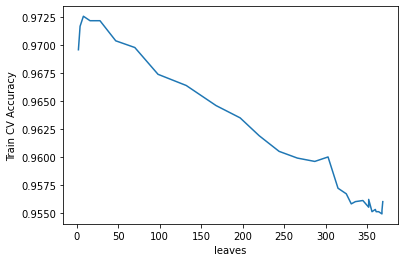

In [8]:
from sklearn.model_selection import cross_val_score
import numpy as np

X2, y2 = X, y
leaves = np.zeros(30)
mean_sc = np.zeros(30)

for i in range(1, 31):
    clf1 = tree.DecisionTreeClassifier(max_depth = i)
    scores = cross_val_score(clf1, X2, y2, cv=10, n_jobs = -1)
    clf1.fit(X2, y2)
    leaves[i - 1] = clf1.get_n_leaves()
    mean_sc[i - 1] = scores.mean()
    
imax = mean_sc.argmax()
print("Max Train CV Accuracy: %0.4f, leaves: %d, depth: %d" % (mean_sc[imax], leaves[imax], imax + 1))

plt.plot(leaves, mean_sc)
plt.xlabel('leaves')
plt.ylabel('Train CV Accuracy')
plt.show()

При большой глубине дерева происходит переобучение классификатора.
## Влияние критериев
В дереве глубины 3 отсутствует критерий student. Проверим влияние двух других критериев на решение.
### Влияние критерия balance

Accuracy for student, income:  0.9645
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1930
           1       0.00      0.00      0.00        70

    accuracy                           0.96      2000
   macro avg       0.48      0.50      0.49      2000
weighted avg       0.93      0.96      0.95      2000



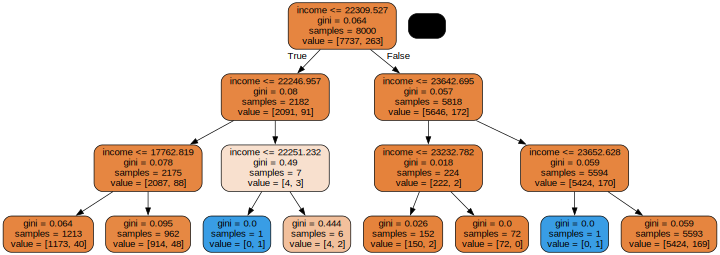

In [9]:
clf2 = tree.DecisionTreeClassifier(max_depth = 3)
X_train2, X_test2, y_train2, y_test2 = X_train, X_test, y_train, y_test
X_not_balance = X_train2[['student', 'income']]
clf2.fit(X_not_balance, y_train2)

y_pred2 = clf2.predict(X_test2[['student', 'income']])
print('Accuracy for student, income: ', accuracy_score(y_test2, y_pred2))
print(classification_report(y_test2, y_pred2))

dot_data = tree.export_graphviz(clf2, out_file=None, feature_names = X_not_balance.columns, filled=True, rounded=True)

pydot_graph = pydotplus.graph_from_dot_data(dot_data)
pydot_graph.set_size('"10!"')

graphviz.Source(pydot_graph.to_string())

Student все еще не учитывается в дереве решений. Качество классификации меньше, чем для всех критериев. Более того, точность классификации неплательщиков нулевая: они практически не нашлись. Значит, критерий balance важен для классификации.
### Влияние критерия income

Accuracy for student, income:  0.97
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1930
           1       0.62      0.36      0.45        70

    accuracy                           0.97      2000
   macro avg       0.80      0.67      0.72      2000
weighted avg       0.96      0.97      0.97      2000



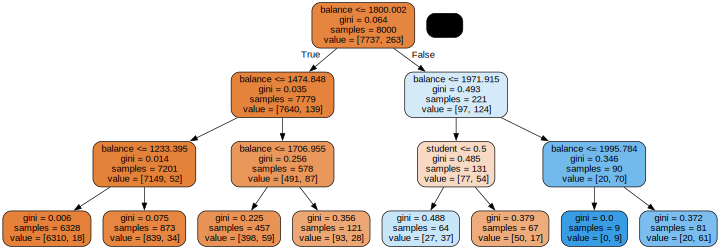

In [10]:
clf3 = tree.DecisionTreeClassifier(max_depth = 3)
X_not_income = X_train2[['student', 'balance']]
clf3.fit(X_not_income, y_train2)

y_pred3 = clf3.predict(X_test2[['student', 'balance']])
print('Accuracy for student, income: ', accuracy_score(y_test2, y_pred3))
print(classification_report(y_test2, y_pred3))

dot_data = tree.export_graphviz(clf3, out_file=None, feature_names = X_not_income.columns, filled=True, rounded=True)

pydot_graph = pydotplus.graph_from_dot_data(dot_data)
pydot_graph.set_size('"10!"')

graphviz.Source(pydot_graph.to_string())

При отсутствии критерия income результаты практически такие же (даже лучше на 0.005), как при наличии всех критериев. Таким образом, income не влияет на улучшение точности классификации, а даже немного портит ее.
### Значимость переменных

In [11]:
print('Feature importances: ', clf.feature_importances_)

Feature importances:  [0.         0.93842237 0.06157763]


Все выводы подтверждаются.
# Пункт 4
## Градиентный бустинг
### Список построенных деревьев, вычисление значимости переменных

In [12]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier()
X_train3, X_test3, y_train3, y_test3 = X_train, X_test, y_train, y_test
gb.fit(X_train3, y_train3)
trees = gb.estimators_
print(trees[0])
print(trees[1])
print(trees[2], '\n')
print('Feature importances: ', gb.feature_importances_)

[DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,
                       random_state=RandomState(MT19937) at 0x2758A2BB040)]
[DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,
                       random_state=RandomState(MT19937) at 0x2758A2BB040)]
[DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,
                       random_state=RandomState(MT19937) at 0x2758A2BB040)] 

Feature importances:  [0.01375834 0.88886477 0.09737689]


Наиболее значимой оказалась переменная balance, как и в случае дерева решений.
### Зависимость качества решения от числа деревьев

5 0.968125
10 0.9728750000000002
15 0.9728749999999999
20 0.9730000000000001
25 0.9731250000000001
30 0.9727500000000001
35 0.9725000000000001
40 0.9723750000000001
45 0.9717499999999999
50 0.9712500000000001
100 0.96975
200 0.967125
300 0.966375
400 0.966
500 0.965625


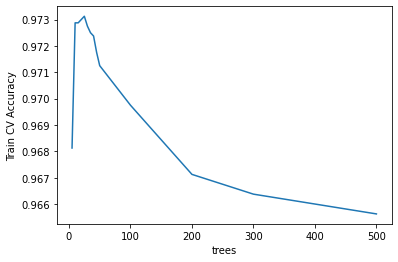

In [13]:
num_trees = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 100, 200, 300, 400, 500]
acc = []

for n_tree in num_trees:
    gb1 = GradientBoostingClassifier(n_estimators=n_tree)
    scores1 = cross_val_score(gb1, X_train3, y_train3, cv=5, n_jobs = -1)
    acc.append(scores1.mean())
    print(n_tree, scores1.mean())

plt.plot(num_trees, acc)
plt.xlabel("trees")
plt.ylabel('Train CV Accuracy')
plt.show()

Наибольшая точность оказалась при использовании 25 деревьев. С увеличением числа деревьев алгоритм сильно переобучается.
# Пункт 5
## Случайный лес
### Вычисление значимости переменных

In [14]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier()
X_train4, X_test4, y_train4, y_test4 = X_train, X_test, y_train, y_test
forest.fit(X_train4, y_train4)
print('Feature importances: ', forest.feature_importances_)

Feature importances:  [0.00508713 0.66634378 0.32856908]


Наиболее значимой оказалась переменная balance, как и двух предыдущих случаях. Переменная income тоже оказалась значимой.
### Зависимость качества решения от числа деревьев

20 0.96875
25 0.9685
50 0.9685
100 0.969125
200 0.968875
300 0.96925
400 0.969375
500 0.969125
1000 0.9695


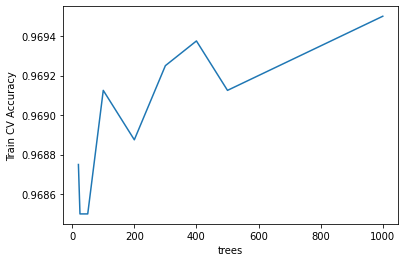

In [15]:
num_trees1 = [20, 25, 50, 100, 200, 300, 400, 500, 1000]
acc1 = []

for n_tree in num_trees1:
    for1 = RandomForestClassifier(n_estimators=n_tree)
    scores1 = cross_val_score(for1, X_train4, y_train4, cv=5, n_jobs = -1)
    acc1.append(scores1.mean())
    print(n_tree, scores1.mean())

plt.plot(num_trees1, acc1)
plt.xlabel("trees")
plt.ylabel('Train CV Accuracy')
plt.show()

Этот метод показал худшие результаты, чем градиентный бустинг на 25 деревьях.
Результаты случайного леса сильно зависят от конкретного построения классификатора.